<a href="https://colab.research.google.com/github/tommy11jo/classifier_experiments/blob/main/classifier_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision

transform = transforms.Compose([transforms.ToTensor()])
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train = datasets.STL10('./data', download=True, split='train', transform=transform)
train_loader = DataLoader(train, batch_size=64)

# Download and load the test data
test = datasets.STL10('./data', download=True, split='test', transform=transform)
test_loader = DataLoader(test, batch_size=64)

100%|██████████| 2640397119/2640397119 [03:52<00:00, 11342797.66it/s]


Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


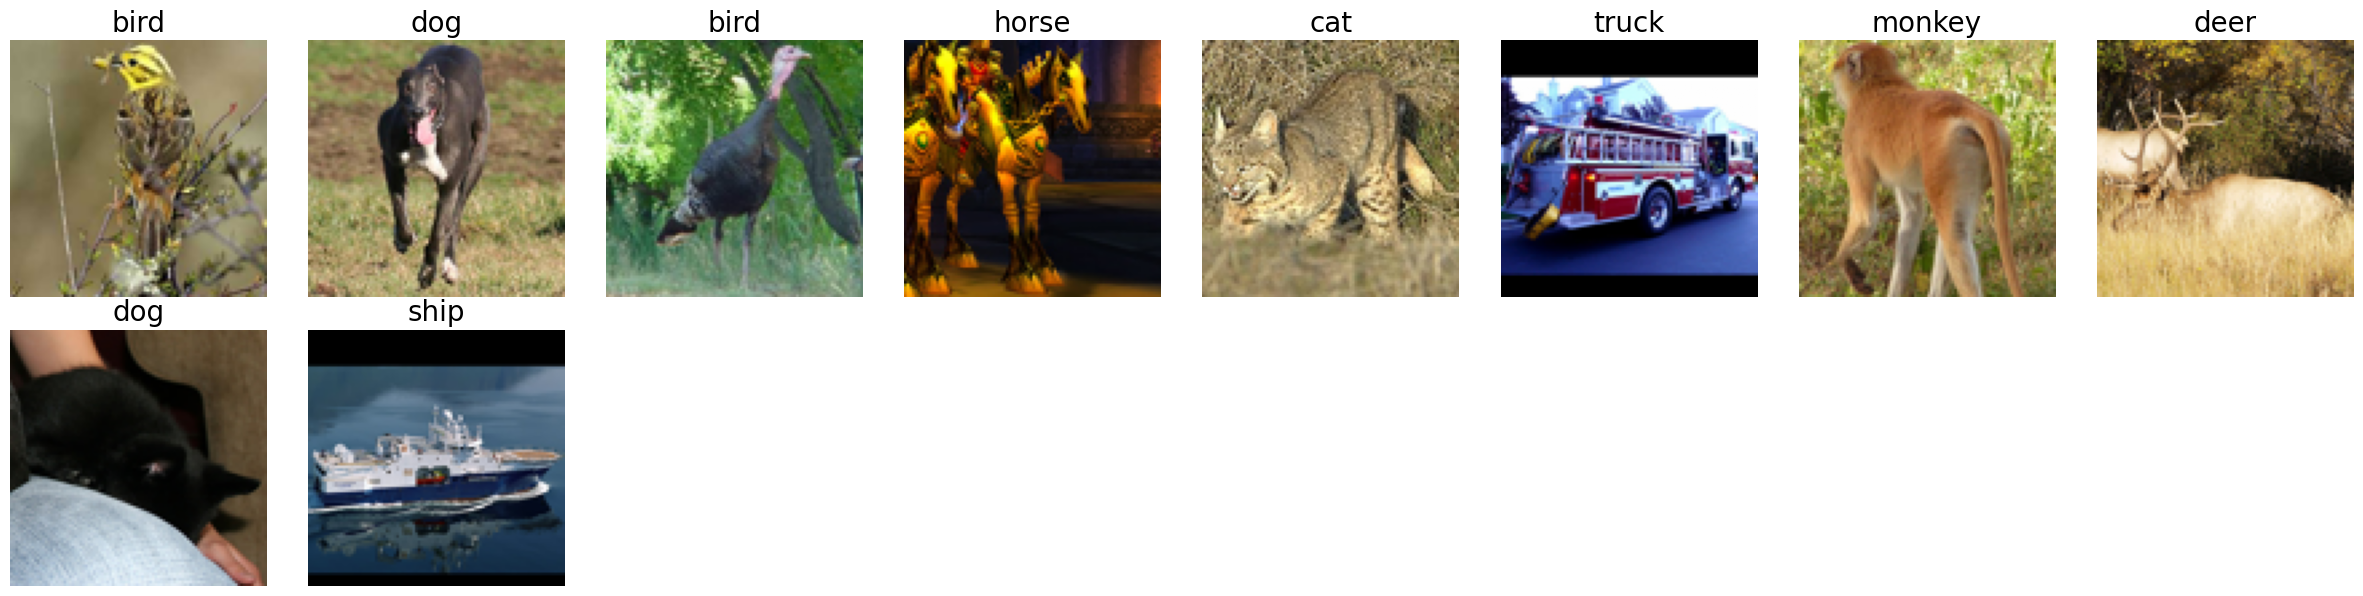

In [2]:
import matplotlib.pyplot as plt
import numpy as np

class_names = train.classes
def imshow(img, label, class_names):
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.title(class_names[label], fontsize=20)
    plt.axis('off')

def multi_imshow(imgs, labels, class_names):
    num_imgs = len(imgs)
    cols = 8
    rows = (len(imgs) // cols) + 1
    plt.figure(figsize=(cols * 3, rows * 3))
    for i in range(num_imgs):
        plt.subplot(rows, cols, i+1)
        imshow(imgs[i], labels[i].item(), class_names)
    plt.tight_layout()
    plt.show()

dataiter = iter(train_loader)
images, labels = next(dataiter)

num_view = 10
multi_imshow(images[:num_view], labels[:num_view], class_names)

print('Image size:', images[0].shape)
print(' '.join(f'{labels[j].item()}' for j in range(num_view)))

In [3]:
train.classes

Image size: torch.Size([3, 96, 96])
1 5 1 6 3 9 7 4 5 8


['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

In [4]:
# Plan: Train straight out, then try training with progressive resizing and see if it improves
# Horse car truck
nclasses = 3
cats = ['car', 'horse', 'truck']
cat_inds = [2, 6, 9]
# cat_inds = [train.classes.index(cat) for cat in cats]
cat_inds.index(6)

1

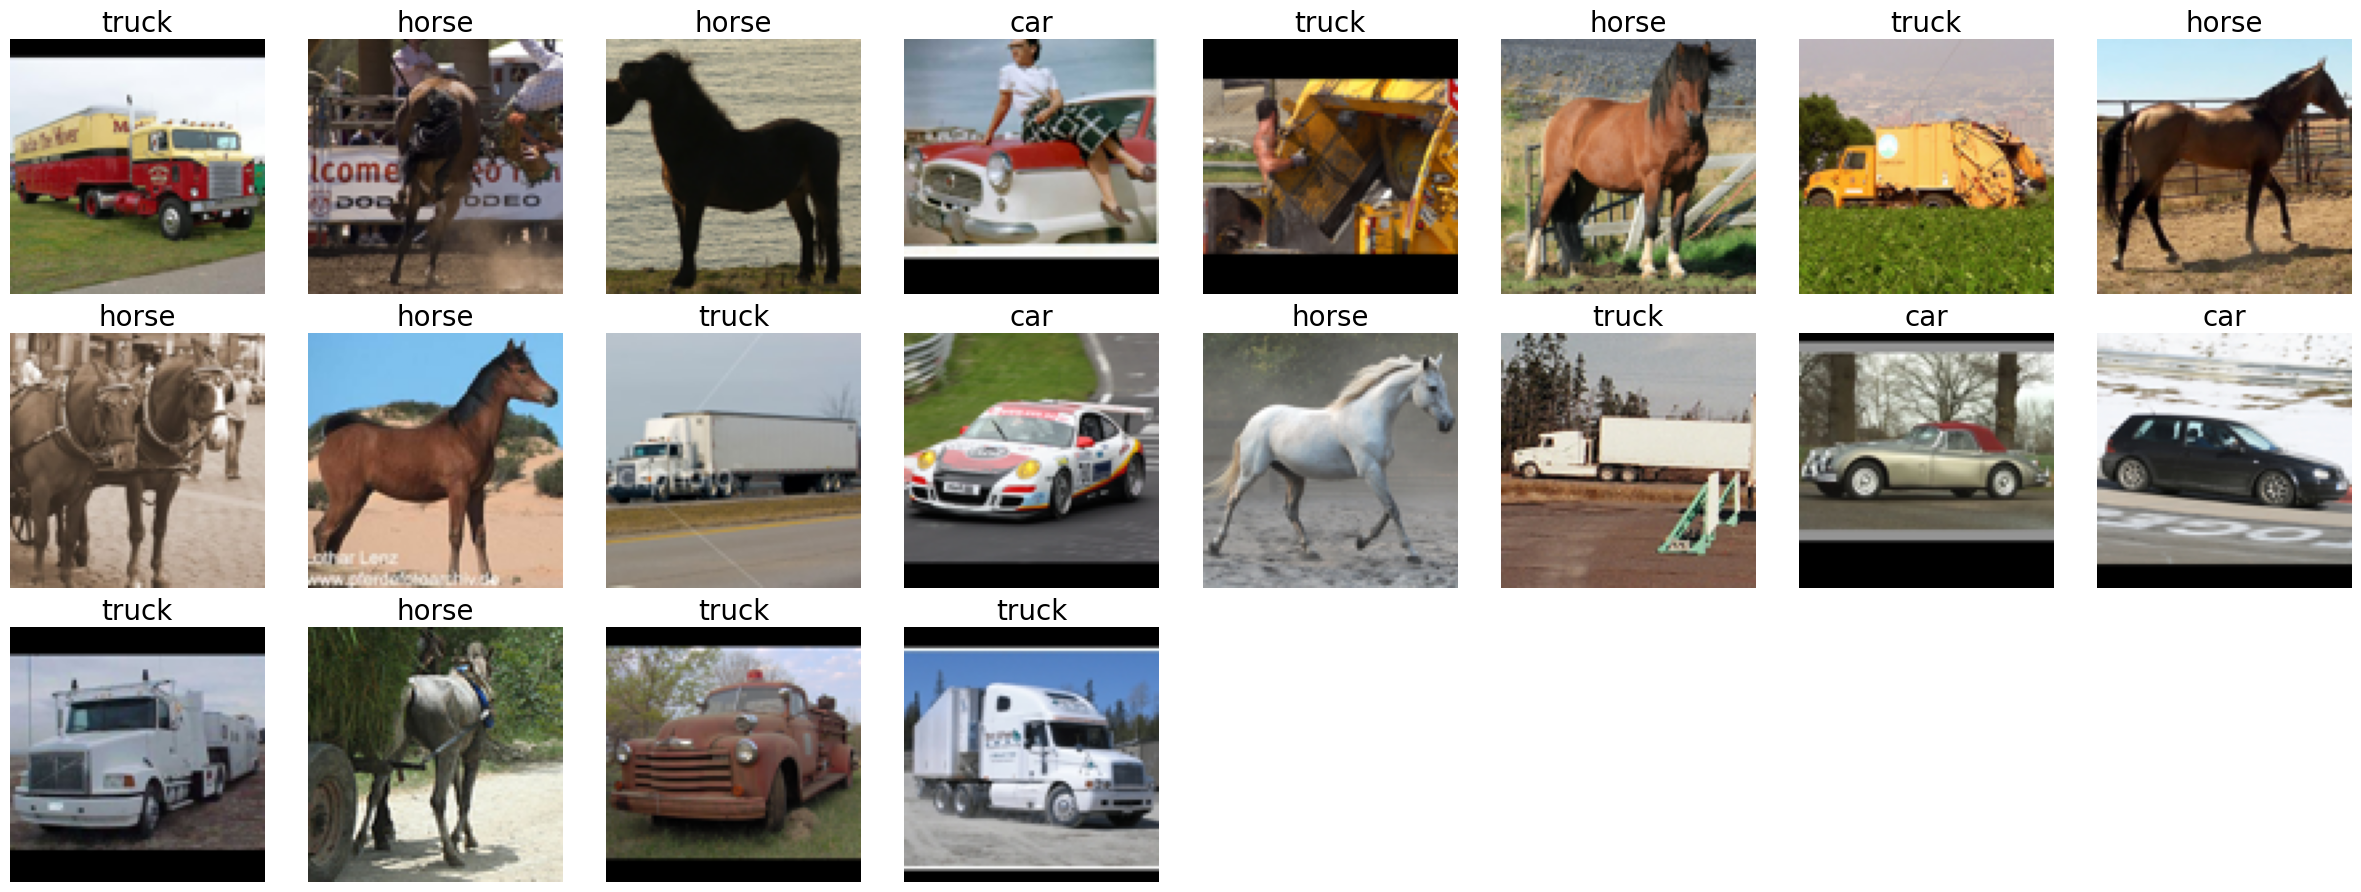

In [12]:
def prepare_data(otrain, otest):
    train = [(data, cat_inds.index(label)) for data, label in otrain if label in cat_inds]
    train_loader = DataLoader(train, batch_size=32, shuffle=True, pin_memory=False)

    test = [(data, cat_inds.index(label)) for data, label in otest if label in cat_inds]
    test_loader = DataLoader(test, batch_size=32, shuffle=True, pin_memory=False)
    return train_loader, test_loader
train_loader, test_loader = prepare_data(train, test)

num_show = 20
train_iter = iter(train_loader)
imgs, labels = next(train_iter)
multi_imshow(imgs[:num_show], labels[:num_show], cats)

In [24]:
import torch
import torchvision.models as models
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, nclasses)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

num_epochs = 4
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(test_loader.dataset)
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

Using cuda device
Epoch 1/4, Loss: 0.2858
Epoch 2/4, Loss: 0.0642
Epoch 3/4, Loss: 0.0327
Epoch 4/4, Loss: 0.0254


In [25]:
def accuracy(loader, max_trials=None):
    running_acc = 0.0
    trials = 0
    for inputs, labels in loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        preds = outputs.argmax(axis=1)
        acc = (preds == labels).sum() / len(inputs)
        running_acc += acc * len(inputs)
        trials += len(inputs)
        if max_trials and trials > max_trials: break

    total_acc = running_acc / trials
    return total_acc
train_acc = accuracy(train_loader, max_trials=400)
test_acc = accuracy(test_loader, max_trials=400)
print('Train acc:', train_acc)
print('Test acc:', test_acc)
# 92% accuracy on resnet 18 with 4 epochs training

Train acc: tensor(0.9976, device='cuda:0')
Test acc: tensor(0.9303, device='cuda:0')


In [8]:
## PLAN ##
# 1. resnet18
# 2. resnet34
# 3. resnet 34, data aug
# 4. reset 34, data aug, label smoothing
# 5. resnet 34, data aug, label smoothing, progressive resizing